# ANALYSE DES DONNEES


In [47]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("ham or spam").getOrCreate() 

df = spark.read.csv("./DataSetEmails/DataSet_Emails.csv", header=True, inferSchema=True,multiLine=True,escape='"')



In [48]:
df.printSchema()

df.show()

root
 |-- _c0: integer (nullable = true)
 |-- message_id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- date: date (nullable = true)

+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|_c0|message_id|                text|label|label_text|             subject|             message|      date|
+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  0|     33214|any software just...|    1|      spam|any software just...|understanding oem...|2005-06-18|
|  1|     11929|perspective on fe...|    0|       ham|perspective on fe...|19 th , 2 : 00 pm...|2001-06-19|
|  2|     19784|wanted to try ci ...|    1|      spam|wanted to try ci ...|viagra at $ 1 . 1...|2004-09-11|
|  3|      2209|enron / hpl actua...|  

In [49]:
from pyspark.sql import functions as f

df.select("message_id").agg(
    f.count("message_id")
).show()
df = df.dropDuplicates()

df.select("message_id").agg(
    f.count("message_id")
).show()

df = df.dropna()

df.select("message_id").agg(
    f.count("message_id")
).show()

+-----------------+
|count(message_id)|
+-----------------+
|            31716|
+-----------------+

+-----------------+
|count(message_id)|
+-----------------+
|            31716|
+-----------------+

+-----------------+
|count(message_id)|
+-----------------+
|            31716|
+-----------------+

+-----------------+
|count(message_id)|
+-----------------+
|            31148|
+-----------------+

+-----------------+
|count(message_id)|
+-----------------+
|            31148|
+-----------------+



In [50]:
df.show()

+----+----------+--------------------+-----+----------+--------------------+--------------------+----------+
| _c0|message_id|                text|label|label_text|             subject|             message|      date|
+----+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  85|     28759|thank you for you...|    0|       ham|thank you for you...|thank you for cha...|2001-08-13|
| 107|     32256|re : account than...|    1|      spam|        re : account|thank you very mu...|2005-03-21|
| 292|     28739|fw : cec natural ...|    0|       ham|fw : cec natural ...|fyi , kim .\n- - ...|2001-08-03|
| 317|     18440|deep penetration ...|    1|      spam|deep penetration ...|download undergro...|2004-03-02|
| 427|      2106|calpine monthly n...|    0|       ham|calpine monthly n...|>\naimee , i am s...|2000-11-27|
| 870|     25411|ggood for you hel...|    1|      spam|       ggood for you|hello , welcome t...|2005-06-23|
|1067|      8777|re

In [51]:
df.groupBy('label').agg(f.count('label')).show()

+-----+------------+
|label|count(label)|
+-----+------------+
|    1|       15645|
|    0|       15503|
+-----+------------+



In [52]:
df_spam = df.filter(f.col('label') == 1)
df_ham = df.filter(f.col('label') == 0)

In [53]:
spam_text = df_spam.agg(
    f.concat_ws(" ", f.collect_list("text")).alias("all_text")
).collect()[0]["all_text"]



In [54]:
ham_text = df_ham.agg(
    f.concat_ws(" ", f.collect_list("text")).alias("all_text")
).collect()[0]["all_text"]

In [55]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


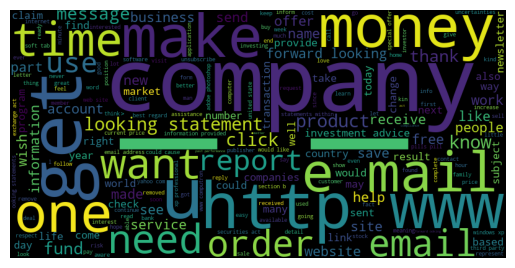

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc_spam = WordCloud(width=800, height=400, stopwords=stop_words).generate(spam_text)
plt.imshow(wc_spam); plt.axis('off') ; plt.show()


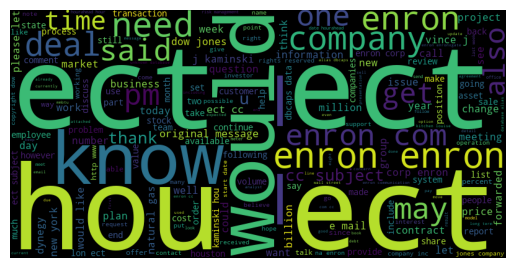

In [57]:
wc_ham = WordCloud(width=800, height=400, stopwords=stop_words).generate(ham_text)
plt.imshow(wc_ham); plt.axis('off'); plt.show() 

In [58]:
print(ham_text)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# pretraitement 


In [59]:
df_normalized = df.withColumn(
    'text',
    f.lower(f.regexp_replace(f.regexp_replace("text", '[^a-zA-Z ]', "")," +", " " ))
    )

In [60]:
df_normalized.show()

+----+----------+--------------------+-----+----------+--------------------+--------------------+----------+
| _c0|message_id|                text|label|label_text|             subject|             message|      date|
+----+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  85|     28759|thank you for you...|    0|       ham|thank you for you...|thank you for cha...|2001-08-13|
| 107|     32256|re account thank ...|    1|      spam|        re : account|thank you very mu...|2005-03-21|
| 292|     28739|fw cec natural ga...|    0|       ham|fw : cec natural ...|fyi , kim .\n- - ...|2001-08-03|
| 317|     18440|deep penetration ...|    1|      spam|deep penetration ...|download undergro...|2004-03-02|
| 427|      2106|calpine monthly n...|    0|       ham|calpine monthly n...|>\naimee , i am s...|2000-11-27|
| 870|     25411|ggood for you hel...|    1|      spam|       ggood for you|hello , welcome t...|2005-06-23|
|1067|      8777|re

In [61]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")

df_tokenized = tokenizer.transform(df_normalized)

In [62]:
df_tokenized.show(truncate=False)

+----+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# stemming or lemmatization 


In [63]:
train_data, test_data, val_data = df_tokenized.randomSplit([0.8, 0.199, 0.001])

In [64]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_tokens(tokens_list):
    if tokens_list is None:
        return []
    return [stemmer.stem(w) for w in tokens_list]

stem_tokens_udf = f.udf(stem_tokens, f.ArrayType(f.StringType()))

train_data_stem = train_data.withColumn("stemmed_tokens",stem_tokens_udf("tokens"))
test_data_stem = test_data.withColumn("stemmed_tokens",stem_tokens_udf("tokens"))
val_data_stem = val_data.withColumn("stemmed_tokens",stem_tokens_udf("tokens"))


In [65]:
dfs = [train_data_stem, test_data_stem ,val_data_stem]

In [66]:
from pyspark.ml.feature import HashingTF, IDF

for i, data in enumerate(dfs) :

    print(i)
    hashing_tf = HashingTF(
        inputCol="stemmed_tokens",
        outputCol="raw_features",
        numFeatures=20000
    )

    df_tf = hashing_tf.transform(data)
    idf = IDF(inputCol="raw_features", outputCol="features")
    tf_idf_model = idf.fit(df_tf)
    
    
    if i==0:
        df_train = tf_idf_model.transform(df_tf)
        df_train = df_train.select("label", "text", "features")
        
    elif i==1:
        df_test = tf_idf_model.transform(df_tf)
        df_test = df_test.select("label", "text", "features")
        
    else:
        df_val = tf_idf_model.transform(df_tf)
        df_val = df_val.select("label", "text", "features")
        


0


1
2
2


In [46]:

df_val.show(truncate=False)


+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# drop les colonnes non necessaire

In [23]:
val_data.agg(f.count("text")).show()

+-----------+
|count(text)|
+-----------+
|         40|
+-----------+



# Entrainement des Model : 

In [68]:
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, LogisticRegression, GBTClassifier


In [25]:

lr = LogisticRegression(featuresCol="features",
                              labelCol="label",
                              maxIter=100,
                              regParam=0.2,
                              elasticNetParam=0.5
                              )

lr_model = lr.fit(df_train)

In [26]:
preds = lr_model.transform(df_test)

evaluation-LinearRegression


In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


auc_eval = BinaryClassificationEvaluator(
    labelCol='label', rawPredictionCol= 'rawPrediction', metricName='areaUnderROC'
)


acc_eval = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='accuracy'
)

f1_eval = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='f1'
)

precision_eval = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='weightedPrecision'
    
)

recall_eval = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='weightedRecall'
    
)


auc_lr = auc_eval.evaluate(preds)
f1_lr = f1_eval.evaluate(preds)
acc_lr = acc_eval.evaluate(preds)
precision_lr = precision_eval.evaluate(preds)
recall_lr = recall_eval.evaluate(preds)



In [28]:
print("------------- LR")
print(f"AUC = {auc_lr:.3f}")
print(f"Accuracy = {acc_lr:.3f}")
print(f"F1-score = {f1_lr:.3f}")
print(f"Precision = {precision_lr:.3f}")
print(f"Recall = {recall_lr:.3f}")

------------- LR
AUC = 0.832
Accuracy = 0.690
F1-score = 0.662
Precision = 0.777
Recall = 0.690


In [30]:
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=50,   # default is 20 – safe
    maxDepth=10,    # VERY important
    maxBins=32,    # lower memory
    subsamplingRate=0.7,
    featureSubsetStrategy="sqrt"
)

rf_model = rf.fit(df_train)

In [31]:
preds_rf = rf_model.transform(df_test)

In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


auc_eval = BinaryClassificationEvaluator(
    labelCol='label', rawPredictionCol= 'rawPrediction', metricName='areaUnderROC'
)


acc_eval = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='accuracy'
)

f1_eval = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='f1'
)

precision_eval = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='weightedPrecision'
    
)

recall_eval = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='weightedRecall'
    
)


auc_rf = auc_eval.evaluate(preds_rf)
f1_rf = f1_eval.evaluate(preds_rf)
acc_rf = acc_eval.evaluate(preds_rf)
precision_rf = precision_eval.evaluate(preds_rf)
recall_rf = recall_eval.evaluate(preds_rf)



In [35]:
print("------------- LR")
print(f"AUC = {auc_rf:.3f}")
print(f"Accuracy = {acc_rf:.3f}")
print(f"F1-score = {f1_rf:.3f}")
print(f"Precision = {precision_rf:.3f}")
print(f"Recall = {recall_rf:.3f}")

------------- LR
AUC = 0.986
Accuracy = 0.909
F1-score = 0.909
Precision = 0.919
Recall = 0.909


In [36]:
# save model rf :

path = "./models/rf_model"

rf_model.write().overwrite().save(path)


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 53210)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/

# Grid Search and Pipeline
Implementation of a Machine Learning Pipeline with Hyperparameter Tuning using Grid Search.

In [69]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Define Pipeline Stages
# We start with HashingTF and IDF, then the Classifier
# Note: We use 'stemmed_tokens' as input which was created in previous steps
hashingTF = HashingTF(inputCol="stemmed_tokens", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# 2. Create the Pipeline
pipeline = Pipeline(stages=[hashingTF, idf, rf])

# 3. Define Hyperparameter Grid
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10000, 20000]) \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# 4. Define Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# 5. Set up CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # 3-fold cross-validation

print("Starting Grid Search with Cross Validation...")
# Fit the model (this may take some time)
cvModel = crossval.fit(train_data_stem)

print("Grid Search Complete.")

Starting Grid Search with Cross Validation...


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 58514)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_192/1606939141.py", line 33, in <module>
    cvModel = crossval.fit(train_data_stem)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/tuning.py", line 862, in _fit
    bestModel = est.fit(dataset, epm[bestIndex])
  File "/usr/local/spark/python/pyspark/ml/base.py", line 203, in fit
    return self.copy(params)._fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/pipeline.py", line 134, in _fit
    model = stage.fit(dataset)
  File "/usr/local/spark/python/pyspark/ml/base.py", line 205, in fit
    return self._fit(datase

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
# Make predictions on test data
predictions_cv = cvModel.transform(test_data_stem)

# Evaluate the best model
accuracy_cv = evaluator.evaluate(predictions_cv)
print(f"Test Accuracy (Best Model): {accuracy_cv:.4f}")

# View best model parameters
best_pipeline_model = cvModel.bestModel
best_rf_model = best_pipeline_model.stages[-1]
print(f"Best Num Trees: {best_rf_model.getNumTrees}")
print(f"Best Max Depth: {best_rf_model.getOrDefault('maxDepth')}")

In [ ]:
# Save the best pipeline model
# This saves the entire pipeline (HashingTF + IDF + RF), so we don't need to manually handle vectorization during inference
path_pipeline = "./models/rf_pipeline_model"
best_pipeline_model.write().overwrite().save(path_pipeline)
print(f"Best pipeline model saved to {path_pipeline}")

# Grid Search and Pipeline - Logistic Regression
Implementation of a Machine Learning Pipeline with Hyperparameter Tuning for Logistic Regression.

In [ ]:
# 1. Define Pipeline Stages for Logistic Regression
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Reuse hashingTF and idf from previous steps
pipeline_lr = Pipeline(stages=[hashingTF, idf, lr])

# 2. Define Hyperparameter Grid for Logistic Regression
paramGrid_lr = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10000, 20000]) \
    .addGrid(lr.regParam, [0.01, 0.1, 0.2]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 50]) \
    .build()

# 3. Set up CrossValidator for Logistic Regression
crossval_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=evaluator,
                             numFolds=3)

print("Starting Grid Search for Logistic Regression...")
# Fit the model
cvModel_lr = crossval_lr.fit(train_data_stem)

print("Grid Search for Logistic Regression Complete.")

In [ ]:
# Make predictions on test data
predictions_cv_lr = cvModel_lr.transform(test_data_stem)

# Evaluate the best model
accuracy_cv_lr = evaluator.evaluate(predictions_cv_lr)
print(f"Test Accuracy (Best LR Model): {accuracy_cv_lr:.4f}")

# View best model parameters
best_pipeline_model_lr = cvModel_lr.bestModel
best_lr_model = best_pipeline_model_lr.stages[-1]
print(f"Best RegParam: {best_lr_model.getRegParam()}")
print(f"Best ElasticNetParam: {best_lr_model.getElasticNetParam()}")
print(f"Best MaxIter: {best_lr_model.getMaxIter()}")

In [ ]:
# Save the best Logistic Regression pipeline model
path_pipeline_lr = "./models/lr_pipeline_model"
best_pipeline_model_lr.write().overwrite().save(path_pipeline_lr)
print(f"Best Logistic Regression pipeline model saved to {path_pipeline_lr}")

# Detailed Evaluation of Pipeline Models
Calculating AUC, Accuracy, F1-score, Precision, and Recall for both the Random Forest and Logistic Regression pipelines on the test data.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Define Evaluators
auc_eval = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
f1_eval = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
precision_eval = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
recall_eval = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
acc_eval = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# --- Random Forest Pipeline Evaluation ---
print("--- Random Forest Pipeline Evaluation ---")
auc_rf_cv = auc_eval.evaluate(predictions_cv)
f1_rf_cv = f1_eval.evaluate(predictions_cv)
acc_rf_cv = acc_eval.evaluate(predictions_cv)
precision_rf_cv = precision_eval.evaluate(predictions_cv)
recall_rf_cv = recall_eval.evaluate(predictions_cv)

print(f"AUC: {auc_rf_cv:.4f}")
print(f"Accuracy: {acc_rf_cv:.4f}")
print(f"F1-score: {f1_rf_cv:.4f}")
print(f"Precision: {precision_rf_cv:.4f}")
print(f"Recall: {recall_rf_cv:.4f}")

# --- Logistic Regression Pipeline Evaluation ---
print("\n--- Logistic Regression Pipeline Evaluation ---")
auc_lr_cv = auc_eval.evaluate(predictions_cv_lr)
f1_lr_cv = f1_eval.evaluate(predictions_cv_lr)
acc_lr_cv = acc_eval.evaluate(predictions_cv_lr)
precision_lr_cv = precision_eval.evaluate(predictions_cv_lr)
recall_lr_cv = recall_eval.evaluate(predictions_cv_lr)

print(f"AUC: {auc_lr_cv:.4f}")
print(f"Accuracy: {acc_lr_cv:.4f}")
print(f"F1-score: {f1_lr_cv:.4f}")
print(f"Precision: {precision_lr_cv:.4f}")
print(f"Recall: {recall_lr_cv:.4f}")